In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

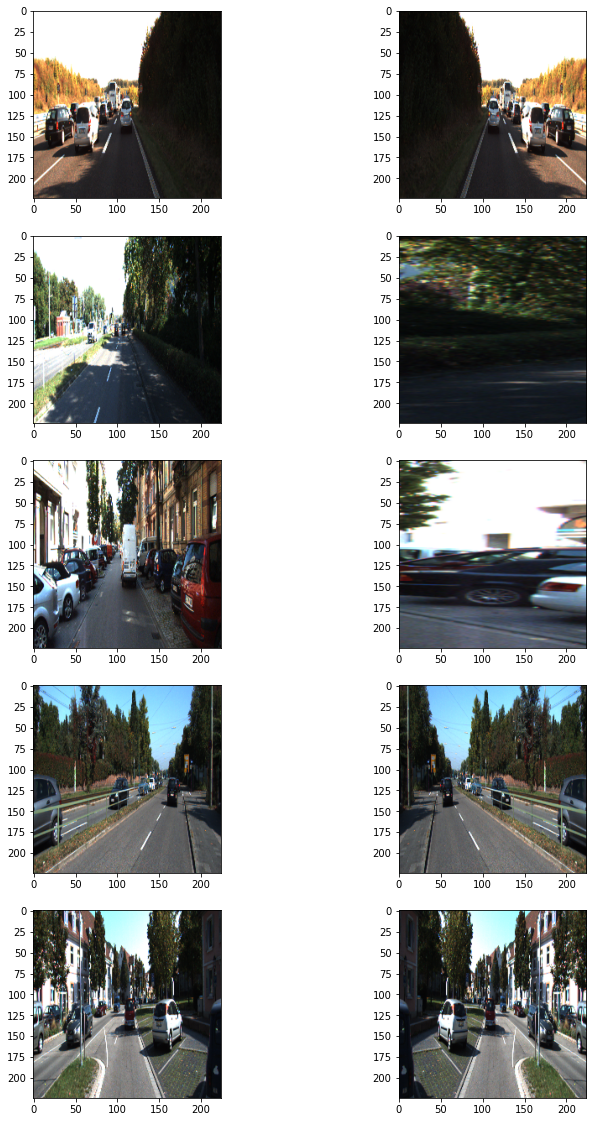

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters, dropout_rate=0.0):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = conv_block(p4, 1024)
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 512)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 256)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 128)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 64)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # 시맨틱 세그멘테이션이므로 sigmoid로 출력

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# 모델 생성
model = build_model(input_shape=(224, 224, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
22/22 [==============================] - 17s 442ms/step - loss: 0.5393 - val_loss: 1.4748

Epoch 00001: val_loss improved from inf to 1.47476, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 2/100
22/22 [==============================] - 9s 418ms/step - loss: 0.3250 - val_loss: 0.9823

Epoch 00002: val_loss improved from 1.47476 to 0.98227, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 3/100
22/22 [==============================] - 10s 421ms/step - loss: 0.2876 - val_loss: 1.5599

Epoch 00003: val_loss did not improve from 0.98227
Epoch 4/100
22/22 [==============================] - 10s 426ms/step - loss: 0.2363 - val_loss: 1.8040

Epoch 00004: val_loss did not improve from 0.98227
Epoch 5/100
22/22 [==============================] - 10s 426ms/step - loss: 0.2718 - val_loss: 0.9120

Epoch 00005: val_loss improved from 0.98227 to 0.91201, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet.h5
Epoch 6

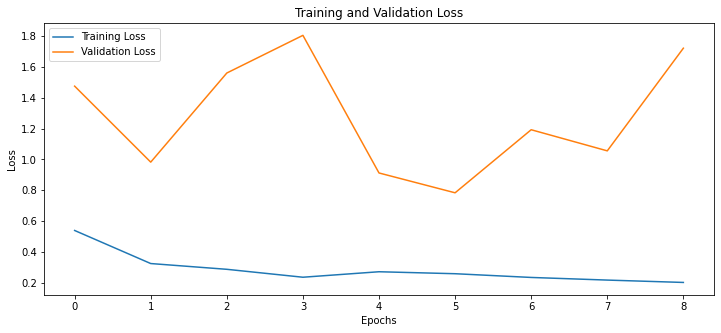

In [21]:
import matplotlib.pyplot as plt

# 학습 그래프 시각화
plt.figure(figsize=(12, 5))

# Training & Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

과적합...

In [22]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

In [23]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

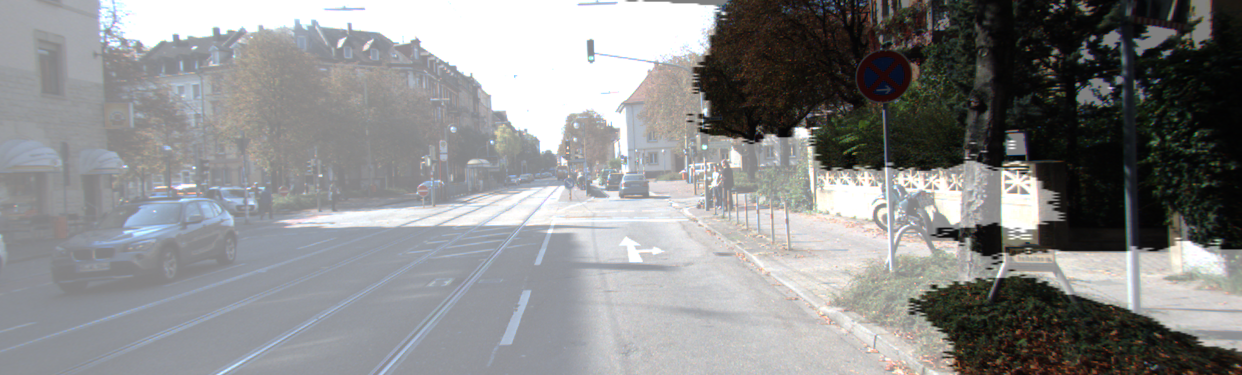

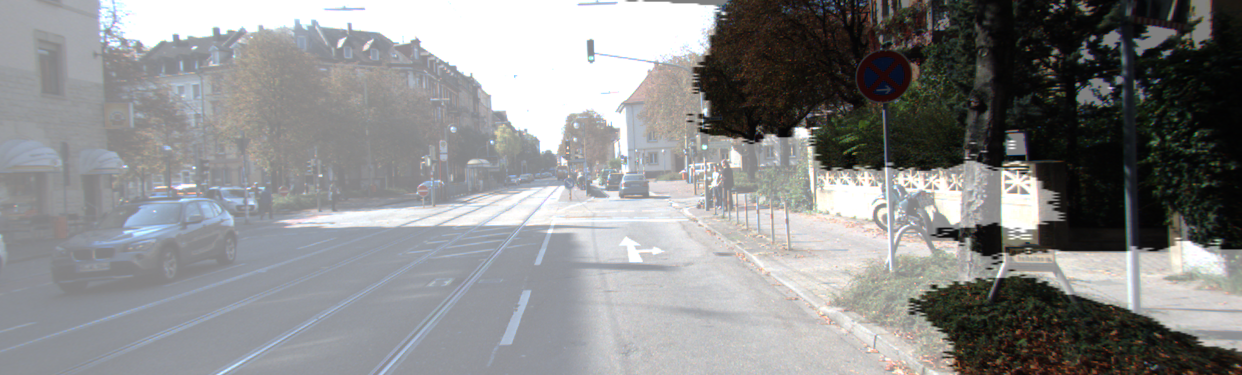

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [25]:
import numpy as np

def calculate_iou_score(target, prediction):
    # Intersection
    intersection = np.logical_and(target, prediction).sum()
    
    # Union
    union = np.logical_or(target, prediction).sum()
    
    # IoU Score
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score)
    
    return iou_score

In [26]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

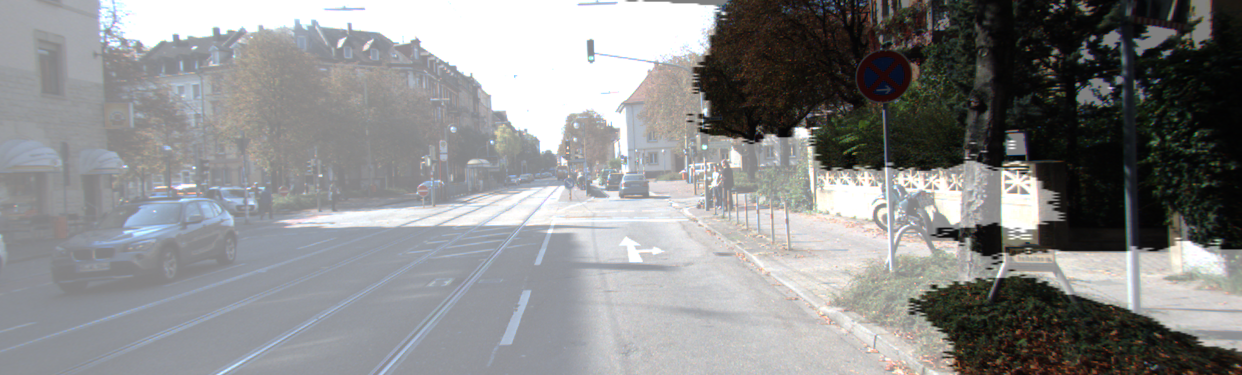

IoU : 0.347195


0.3471945392491468

In [27]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# 프로젝트 진행에 필요한 주요 라이브러리 버전 체크를 해봅시다.

In [15]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


# Step 1. KITTI 데이터셋 수집과 구축
- 다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다.
- 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 
- 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [16]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, Resize

# Step 1. KITTI Dataset Collection and Augmentation
def build_augmentation(is_train=True):
    if is_train:    # Training dataset augmentation
        return Compose([
            HorizontalFlip(p=0.5),  # 50% chance horizontal flip
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(width=224, height=224)  # Resize image to 224x224
        ])
    return Compose([Resize(width=224, height=224)])  # Testing dataset only resize

dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)

class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, dir_path, batch_size=8, img_size=(224, 224, 3), output_size=(224, 224), is_train=True, augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
            return self.indexes

train_generator = KittiGenerator(dir_path, augmentation=augmentation_train)
test_generator = KittiGenerator(dir_path, augmentation=augmentation_test, is_train=False)

# Step 2. U-Net++ 모델의 구현
- U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 
- 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 
- 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def conv_block(inputs, num_filters, dropout_rate=0.3, use_residual=True):
    x = Conv2D(num_filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_filters, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    
    if use_residual:
        # 입력 채널과 출력 채널이 다를 때 Conv2D로 입력 채널을 맞춤
        shortcut = Conv2D(num_filters, (1, 1), kernel_initializer='he_normal', padding='same')(inputs)
        x = tf.keras.layers.add([shortcut, x])  # Residual connection
    return x

def build_unet_plus_plus(input_shape=(224, 224, 3)):
    tf.keras.backend.clear_session()
    nb_filter = [32, 64, 128, 256, 512]

    inputs = Input(input_shape)
    s = Lambda(lambda x: x / 255)(inputs)

    # Encoder Blocks with more filters and residuals
    c1 = conv_block(s, nb_filter[0])
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, nb_filter[1])
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, nb_filter[2])
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, nb_filter[3])
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, nb_filter[4])

    # Decoder Blocks with dense skip connections
    u4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), padding='same')(c5)
    c4_2 = concatenate([u4_2, c4])
    c4_2 = conv_block(c4_2, nb_filter[3])

    u3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), padding='same')(c4_2)
    c3_2 = concatenate([u3_2, c3])
    c3_2 = conv_block(c3_2, nb_filter[2])

    u2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), padding='same')(c3_2)
    c2_2 = concatenate([u2_2, c2])
    c2_2 = conv_block(c2_2, nb_filter[1])

    u1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), padding='same')(c2_2)
    c1_2 = concatenate([u1_2, c1])
    c1_2 = conv_block(c1_2, nb_filter[0])

    # Output layer (Adjust activation if needed)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c1_2)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

# Model creation
unet_model = build_unet_plus_plus(input_shape=(224, 224, 3))
unet_model.compile(optimizer=Adam(1e-4), loss=dice_loss, metrics=[iou])

# Callbacks for training
checkpoint_path = 'unetpp_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Model training
history = unet_model.fit(
    train_generator,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
22/22 [==============================] - 10s 335ms/step - loss: 0.6330 - iou: 0.2290 - val_loss: 0.5618 - val_iou: 0.2836

Epoch 00001: val_loss improved from inf to 0.56176, saving model to unetpp_checkpoint.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
22/22 [==============================] - 7s 299ms/step - loss: 0.4862 - iou: 0.3541 - val_loss: 0.4767 - val_iou: 0.3569

Epoch 00002: val_loss improved from 0.56176 to 0.47671, saving model to unetpp_checkpoint.h5
Epoch 3/100
22/22 [==============================] - 7s 299ms/step - loss: 0.4072 - iou: 0.4333 - val_loss: 0.4820 - val_iou: 0.3520

Epoch 00003: val_loss did not improve from 0.47671
Epoch 4/100
22/22 [==============================] - 7s 302ms/step - loss: 0.3990 - iou: 0.4408 - val_loss: 0.3713 - val_iou: 0.4599

Epoch 00004: val_loss improved from 0.47671 to 0.37131, saving model to unetpp_checkpoint.h5
Epoch 5/100
22/22 [==============================] - 7s 301ms/step - loss: 0.3673 - iou: 0.4765 - val_loss: 0.3874 - val_iou: 0.4451

Epoch 00005: val_loss did not improve from 0.37131
Epoch 6/100
22/22 [==============================] - 7s 303ms/step - loss: 0.3086 - iou: 0.5464 - val_loss: 0.4472 - val_iou: 0.3854

Epoch 00006: val_loss did not improve from

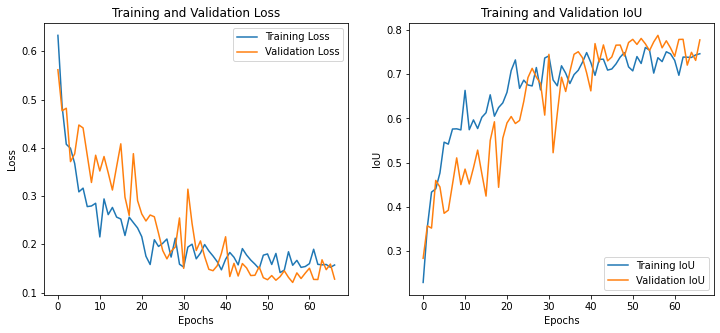

In [32]:
# 학습 그래프 시각화
plt.figure(figsize=(12, 5))

# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training & Validation IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

plt.show()

뭐야?

# Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
- 두 모델의 정량적, 정성적 성능을 비교해 봅시다. 
- 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

IoU : 0.848781


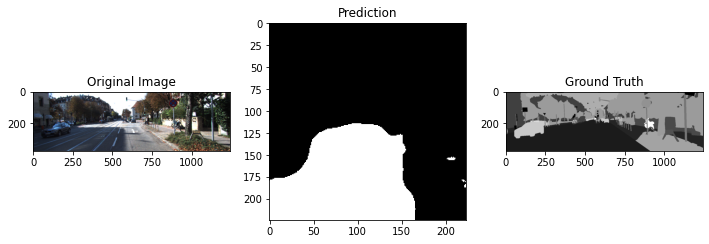

In [33]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score)
    return iou_score

def get_output(model, preproc, image_path, label_path):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    output = (output[0].numpy() >= 0.5).astype(np.uint8).squeeze(-1) * 255
    prediction = output / 255

    # Visualize the result
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(origin_img)
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(output, cmap='gray')

    if label_path:
        label_img = imread(label_path)
        label_data = {"image": label_img}
        label_processed = preproc(**label_data)
        target = (label_processed["image"] == 7).astype(np.uint8) * 1
        plt.subplot(1, 3, 3)
        plt.title("Ground Truth")
        plt.imshow(label_img, cmap='gray')
        calculate_iou_score(target, prediction)

    plt.show()

# Visualize and calculate IoU for a specific test image
i = 1
get_output(
    unet_model,
    augmentation_test,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

# 회고
- 그래프 보고 이게 맞나 싶다
- 시간이 부족해
- 뭐가 문제인지 탐구할 필요가 음